# 네이버 영화리뷰 감성분석 도전하기



![img](https://github.com/riverlike/Aiffel_Project/blob/main/Exploration/Exp06/data/wordcloud.png?raw=true)


이번프로젝트에서는  한국어 텍스트의 감정 분석을 진행해볼것이다.
활용할 데이터셋은 네이버 영화의 댓글을 모아 구성된 [Naver sentiment movie corpus](https://github.com/e9t/nsmc) 이다.
해당 파일의 심볼릭 링크를 연결해주었다. 
```
ln -s ~/data/*.txt ~/aiffel/project/exp06_Movie_Review/data
```

# 1. 라이브러리

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 2. 데이터 준비

### 2.1 네이버 영화리뷰 파일 읽기
- ratings_train.txt: 150K reviews for training
- ratings_test.txt: 50K reviews held out for testing

In [2]:
# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/project/exp06_Movie_Review/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/project/exp06_Movie_Review/data/ratings_test.txt')


In [3]:
train_data.shape, test_data.shape

((150000, 3), (50000, 3))

훈련 데이터 15만건, 테스트 데이터 5만건이 확인된다. 데이터 내부를 좀 더 살펴보자.

In [4]:
train_data.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        150000 non-null  int64 
 1   document  149995 non-null  object
 2   label     150000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.4+ MB


In [5]:
train_data.head(3)

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0


영화리뷰 분석을 위해 document 컬럼 데이터를 중심적으로 살펴보면될것 같다. 타킷 데이터는 label에 들어가있다.
데이터 로더 함수 구현전에 train_data및 test_data에서 중복 데이터와 결측치가 없는지 확인해보겠다

In [6]:
train_data.isna().sum().sum(), test_data.isna().sum().sum()

(5, 3)

In [7]:
train_data.shape[0] - len(train_data['document'].unique()), test_data.shape[0]  - len(test_data['document'].unique())

(3817, 842)

결측치가 훈련 데이터 5건, 테스트 3건있으며, 중복데이터는 훈련 데이터 3817건, 테스트 842건 확인되었다. 
결측치와 중복데이터가 전체데이터에 비해 큰 비중이 아니므로 삭제해서 마지막 데이터셋을 구성해야하겠다.

이제 라벨데이터 데이터의 분포를 확인해보겠다.


<AxesSubplot:>

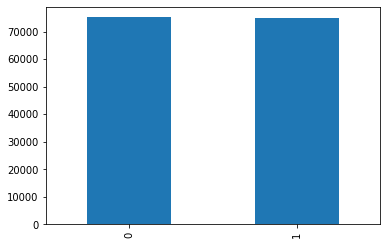

In [8]:
train_data['label'].value_counts().plot(kind='bar')

긍정(1) 부정(0)의 비율이 균등하게 분포하는 것으로 보인다. 이제 위 데이터로 모델 학습을 위한 데이터셋을 구성하기위해 문장의 토큰화및 인코딩작업을 해보고 데이터 로더함수를 만들어보겠다.

### 2.2 데이터 토큰화 및 단어사전(word_to_index) 만들기


토큰화및 전처리와 관련해 필요한 라이브러리이다.

라이브러리
- konlpy : 파이썬 한국어 형태소 분석 패키지, Okt, Komoran, Kkma, Mecab 등 여러가지 형태소 분석기를 포함하고 있다.
 - Mecab : 일본어용 형태소 분석기를 한국어를 사용할 수 있도록 수정한 것. 속도및 분석성능이 좋다고함.
- Counter : 데이터의 개수를 셀 때 유용한 파이썬의 collections 모듈의 클래스


In [9]:
from konlpy.tag import Mecab
from collections import Counter

임의로 아래 두문장에대해서 데이터 전처리 작업을 진행해보겠다.

In [14]:
sentence = "괜찮은 음악영화가 또 나왔군요 따뜻한 겨울이 될 것 같아요"
sentence2 = "아이들 영화로 최고인것 같다! 몬스터 주식회사 영화 3D로 재밌게 봤다 또 보고싶다"

In [15]:
# 한국어 토크나이저로 토큰화 
tokenizer = Mecab()

# 토큰화
tokenized_sentence = tokenizer.morphs(sentence) 
tokenized_sentence2 = tokenizer.morphs(sentence2) 
print(tokenized_sentence)
print(tokenized_sentence2)

['괜찮', '은', '음악', '영화', '가', '또', '나왔', '군요', '따뜻', '한', '겨울', '이', '될', '것', '같', '아요']
['아이', '들', '영화', '로', '최고', '인', '것', '같', '다', '!', '몬스터', '주식회사', '영화', '3', 'D', '로', '재밌', '게', '봤', '다', '또', '보', '고', '싶', '다']


In [17]:
#토큰화된 문장에서 불용어(Stopwords) 제거
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']
stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
stopwords_removed_sentence2 = [word for word in tokenized_sentence2 if not word in stopwords] # 불용어 제거
print(stopwords_removed_sentence)        
print(stopwords_removed_sentence2)    

['괜찮', '음악', '영화', '또', '나왔', '군요', '따뜻', '겨울', '될', '것', '같', '아요']
['아이', '영화', '로', '최고', '인', '것', '같', '다', '!', '몬스터', '주식회사', '영화', '3', 'D', '로', '재밌', '게', '봤', '다', '또', '보', '고', '싶', '다']


불용어가 제거되었는지 확인해보자

In [18]:
stopwords_removed_sentence

['괜찮', '음악', '영화', '또', '나왔', '군요', '따뜻', '겨울', '될', '것', '같', '아요']

토큰화된 단어들에서 은, 가, 들등의 불용어가 제거된 모습이다. 이 단어들중 사용 빈도수가 높은 단어로 word_to_index 를 구성하겠다.

In [20]:
#두개의 문장으로 단어별 사전인덱스를 만들것이다.
review_list = [stopwords_removed_sentence, stopwords_removed_sentence2]
#데이터셋의 모든 문장을 붙인후 단어를 추출
words = np.concatenate(review_list).tolist()
len(words)    

36

In [21]:
#36개의 단어들중 빈도수가 많은 단어만 뽑겠다. - 상위 26개
counter = Counter(words)
counter = counter.most_common(30-4) #4개 : 특수토큰이다. 4개를제외한 빈도수가 높은 단어 26개를 포함시킨다.
vocab = ['<PAD>', '<BOS>', '<EOS>', '<UNK>'] + [key for key, _ in counter] #특수토큰

#단어들에 인덱스를 부여
word_to_index = {word:index for index, word in enumerate(vocab)}
word_to_index

{'<PAD>': 0,
 '<BOS>': 1,
 '<EOS>': 2,
 '<UNK>': 3,
 '영화': 4,
 '다': 5,
 '또': 6,
 '것': 7,
 '같': 8,
 '로': 9,
 '괜찮': 10,
 '음악': 11,
 '나왔': 12,
 '군요': 13,
 '따뜻': 14,
 '겨울': 15,
 '될': 16,
 '아요': 17,
 '아이': 18,
 '최고': 19,
 '인': 20,
 '!': 21,
 '몬스터': 22,
 '주식회사': 23,
 '3': 24,
 'D': 25,
 '재밌': 26,
 '게': 27,
 '봤': 28,
 '보': 29}

상위 30개 단어가 숫자와 매칭된 단어사전(word_to_index)이 만들어졌다.
리뷰 문장을 위에서 만든 사전의 단어와 매칭이되는 인덱스로 변경하겠다.

In [23]:
# 인덱스 스트링으로 변환 : word_to_index에 없는 단어에는 <UNK> 토큰을 설정한다.
def wordlist_to_indexlist(wordlist):
    return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

index_review = list(map(wordlist_to_indexlist, review_list))
index_review[0]

[10, 11, 4, 6, 12, 13, 14, 15, 16, 7, 8, 17]

### 텍스트 분석을 위한 인코더, 디코더 함수
인덱스 스트링(숫자 벡터로 encode된 문장)을 원래문장으로 decode해보자.
아래는 인코딩, 디코딩 관련 함수들이다.

In [10]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [26]:
index_to_word = {index:word for word, index in word_to_index.items()}

decoded_sentence = get_decoded_sentence([10, 11, 4, 6, 12, 13, 14, 15, 16, 7, 8, 17], index_to_word)
decoded_sentence

'음악 영화 또 나왔 군요 따뜻 겨울 될 것 같 아요'

빈도수가 작은 단어나 불용어가 제거되었지만 문장복원이 잘되는 모습이다. 이제 위에서 진행된 사항을 반영해서 네이버 리뷰문장을 전처리해주어 데이터셋을 구성하는 함수를 만들어보겠다.

### 2.3 load_data 함수 

텍스트를 가공하여 숫자 인덱스로 변환된 텍스트와 word_to_index 딕셔너리 리턴하는 함수이다. 

- 데이터의 중복 제거

- NaN 결측치 제거

- 한국어 토크나이저로 토큰화

- 불용어(Stopwords) 제거
 - 불용어 : 언어를 분석할 때 의미가 없는 단어나 조사 등을 말함.
 - Mecab.morphs() : 문장을 형태소 단위로 나누어줍니다

- 사전word_to_index 구성 : 사용빈도수가 높은 최상위 1만개단어

- 텍스트 스트링을 사전 인덱스 스트링으로 변환

- X_train, y_train, X_test, y_test, word_to_index 리턴

In [11]:
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    # 데이터의 중복 제거
    train_data.drop_duplicates(subset=['document'], inplace=True)
    test_data.drop_duplicates(subset=['document'], inplace=True)
    
    # NaN 결측치 제거
    train_data = train_data.dropna(how = 'any') 
    test_data = test_data.dropna(how = 'any')     
    
    # 한국어 토크나이저로 토큰화 및 불용어(Stopwords) 제거
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)    
    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
   
    # 사전word_to_index 구성
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)  #사용빈도수가 높은 최상위 1만개단어 - 4개는 특수토큰
    vocab = ['<PAD>', '<BOS>', '<EOS>', '<UNK>'] + [key for key, _ in counter] #특수토큰
    word_to_index = {word:index for index, word in enumerate(vocab)}
    
    # 텍스트 스트링을 사전 인덱스 스트링으로 변환
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [12]:
X_train[:3]

[[32, 74, 919, 4, 4, 39, 228, 20, 33, 748],
 [1028, 4, 11, 519, 549, 687, 5, 120, 4, 70, 1639, 52, 925, 1006, 15, 44, 391],
 [24, 205, 3]]

데이터 로더에 의해 불러온 훈련데이터셋중 3문장만 출력해보았다. 위 3 문장이 포함한 단어의 수가(아래에서 문장의 길이로 통칭) 모두 다르다. 이부분도 전처리가 필요하다.

### 2.4 모델 구성을 위한 데이터 분석 및 가공
훈련 데이터 15만건, 테스트 데이터 5만건에 존재하는 문장의 길이가 다르다. 모델에 학습될 데이터는 같은 길이로 넣어주어야 하기때문에 전처리를 해주어야한다. 전체 데이터셋의 문장길이 분포를 알아보고 적절한 최대 문장길이를 설정해보겠다.

- 데이터셋 내 문장 길이 분포
- 적절한 최대 문장 길이 지정
- keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

In [13]:
index_to_word = {index:word for word, index in word_to_index.items()}

### 2.4 - 1 데이터셋 내 문장 길이 분포

In [14]:
print("가장 많은 단어를 포함한 문장의 길이:",  max(len(sentence) for sentence in X_train))
print('문장의 평균 단어수:', sum(map(len, X_train))/len(X_train))

가장 많은 단어를 포함한 문장의 길이: 116
문장의 평균 단어수: 15.98170773419436


데이터셋 내에 존재하는 문장 길이에 대한 분포를 시각해보자. 리뷰의 평균길이는 16정도 되고 길이가 100이 넘는 경우도 있다.  

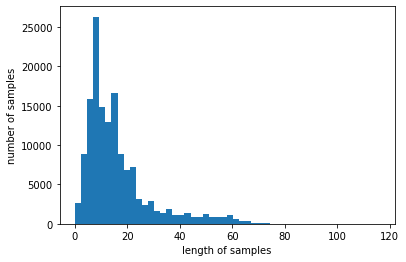

In [15]:
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

시각화를 해서보니 문장의 길이가 60이상에 해당하는 리뷰 건수가 적은것같다. 전체에서 60이상인 샘플이 어느정보 인지 살펴보고 최대문장길이를 지정해보도록하겠다

In [16]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

### 2.4 - 2 적절한 최대 문장 길이 지정

In [17]:
max_len = 60 
below_threshold_len(max_len, X_train)
below_threshold_len(max_len, X_test)

전체 샘플 중 길이가 60 이하인 샘플의 비율: 98.8343298080475
전체 샘플 중 길이가 60 이하인 샘플의 비율: 98.78755823178794


리뷰의 길이가 60이하인 데이터셋의 비율이 98%이상이 되기때문에 훈련에 문제가 없을것 같다. 60을 최대문장 길이로 지정하고 60이하인 문장에 대해서는 앞쪽으로 패딩을 넣어주도록하겠다. 

### 2.4 - 3 keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

Tensorflow의 pad_sequences 
- 문장 벡터에 패딩을 추가하여 길이를 일정하게 맞춰준다.
- padding 방식 
 - post : 문장 뒤쪽에 패딩을 추가
 - pre : 문장 앞쪽에 패딩을 추가
 
RNN의 학습구조상 입력데이터가 순차적으로 처리되어, 가장 마지막 입력이 최종 state 값에 가장 영향을 많이 미치므로 마지막 데이터가 유의미할수록 성능이 10% 이상 좋다고 한다. 따라서 pre옵션을 선택하는것이 좋을 것 같다.

In [18]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_len = 60
X_train = pad_sequences(X_train, padding='pre', maxlen=max_len)
X_test = pad_sequences(X_test, padding='pre', maxlen=max_len)

In [40]:
X_train[1]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0, 1028,
          4,   11,  519,  549,  687,    5,  120,    4,   70, 1639,   52,
        925, 1006,   15,   44,  391], dtype=int32)

In [41]:
len(X_train[1])

60

In [19]:
get_decoded_sentence(X_train[1],  index_to_word)

'<PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 흠 . .. 포스터 보고 초딩 영화 줄 . ... 오버 연기 조차 가볍 지 않 구나'

리뷰의 문장길이가 60이고 문장의 앞쪽에 패딩이 들어간것이 확인되었다. 인코딩 문장을 디코딩했을때 복원도 잘되는 모습이다. 이제 이 데이터로 모델학습을 시켜보겠다.

# 3. 모델 구성 및 validation set 구성
이번 프로젝트에서는 3가지 모델을 통해 리뷰를 분석하고 긍정부정을 분류하는 예측을 진행해보려한다.


In [20]:
import os 
import tensorflow as tf
from tensorflow import keras

embedding_dim = 200
vocab_size = len(index_to_word)  # 어휘 사전의 크기입니다(10000개의 단어)
vocab_size

10000

### 3.1 SimpleRNN 모델
RNN에 대한 기본적인 아이디어는 순차적인 정보를 처리한다는 데 있다.
이론적으로 RNN은 임의의 길이의 시퀀스 정보를 처리할 수 있지만, 실제로는 비교적 짧은 시퀀스만 효과적으로 처리할 수 있다

Embedding 레이어 
 - 의미 벡터 공간에서 단어의 추상적 표현하기위해 1차원입력정보를 2차원으로 변경한다.
 - vocab_size : 단어사전 사이즈
 - embedding_dim: 토큰화된 단어를 지정된 차원의 벡터로 표현
 
SimpleRNN 레이어   
 - hidden_size : 128
 - 데이터를 이해하는 은닉층의 노드의 수
 
Dense 레이어 
 - SimpleRNN 출력인 은닉상태 128개 값을 8개로 줄인다.
 - 최종 출력은 긍정/부정을 나타내는 1차원 값이다.

In [89]:
rnn_model = keras.Sequential()
rnn_model.add(keras.layers.Embedding(vocab_size, embedding_dim)) #1만개의 단어에 대해 embedding_dim 벡터로 표현
rnn_model.add(keras.layers.SimpleRNN(128))
rnn_model.add(keras.layers.Dense(8, activation='relu'))
rnn_model.add(keras.layers.Dense(1, activation='sigmoid'))

rnn_model.compile(optimizer='adam', 
              loss='binary_crossentropy', #이전분류를 위한 손실함수
              metrics=['accuracy'])
rnn_history = rnn_model.fit(X_train, y_train, epochs=5,  validation_split=0.2)

Epoch 1/5
3655/3655 [==============================] - 178s 49ms/step - loss: 0.4497 - accuracy: 0.7886 - val_loss: 0.3882 - val_accuracy: 0.8286
Epoch 2/5
3655/3655 [==============================] - 176s 48ms/step - loss: 0.4094 - accuracy: 0.8201 - val_loss: 0.4277 - val_accuracy: 0.8146
Epoch 3/5
3655/3655 [==============================] - 177s 48ms/step - loss: 0.3728 - accuracy: 0.8412 - val_loss: 0.4308 - val_accuracy: 0.8106
Epoch 4/5
3655/3655 [==============================] - 176s 48ms/step - loss: 0.3869 - accuracy: 0.8352 - val_loss: 0.3952 - val_accuracy: 0.8317
Epoch 5/5
3655/3655 [==============================] - 176s 48ms/step - loss: 0.3556 - accuracy: 0.8493 - val_loss: 0.3853 - val_accuracy: 0.8341


### 3.2 LSTM 모델

LSTM(Long Short-Term Memory, LSTM) : RNN 구조에 비해 더 긴 시퀀스를 효과적으로 잘 기억한다. LSTM에서는 RNN의 뉴런 대신에 메모리 셀이라고 불리는 구조를 사용해 긴 시퀀스를 기억하는데 매우 효과적이다.


In [91]:
lstm_model = keras.Sequential()
lstm_model.add(keras.layers.Embedding(vocab_size, embedding_dim))
lstm_model.add(keras.layers.LSTM(128))
lstm_model.add(keras.layers.Dense(8, activation='relu'))
lstm_model.add(keras.layers.Dense(1, activation='sigmoid'))

lstm_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

lstm_history = lstm_model.fit(X_train, y_train, epochs=5,  validation_split=0.2)

Epoch 1/5
3655/3655 [==============================] - 25s 7ms/step - loss: 0.3636 - accuracy: 0.8374 - val_loss: 0.3131 - val_accuracy: 0.8651
Epoch 2/5
3655/3655 [==============================] - 23s 6ms/step - loss: 0.2769 - accuracy: 0.8822 - val_loss: 0.3039 - val_accuracy: 0.8703
Epoch 3/5
3655/3655 [==============================] - 24s 6ms/step - loss: 0.2292 - accuracy: 0.9055 - val_loss: 0.3225 - val_accuracy: 0.8675
Epoch 4/5
3655/3655 [==============================] - 24s 6ms/step - loss: 0.1855 - accuracy: 0.9251 - val_loss: 0.3566 - val_accuracy: 0.8651
Epoch 5/5
3655/3655 [==============================] - 23s 6ms/step - loss: 0.1455 - accuracy: 0.9415 - val_loss: 0.3956 - val_accuracy: 0.8621


### 3.3 Gru모델 
GRU (Gated Recurrent Unit) : 대부분 LSTM과 비슷한 성질을 갖지만 더 간단한 구조를 갖고 있다.  파라미터 수가 적어서 학습 시간이 더 짧게 걸리고 보다 적은 데이터로도 학습이 가능하다.

In [93]:
gru_model = keras.Sequential()
gru_model.add(keras.layers.Embedding(vocab_size, embedding_dim))
gru_model.add(keras.layers.GRU(128))
gru_model.add(keras.layers.Dense(8, activation='relu'))
gru_model.add(keras.layers.Dense(1, activation='sigmoid'))

gru_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

gru_history = gru_model.fit(X_train, y_train, epochs=5,  validation_split=0.2)

Epoch 1/5
3655/3655 [==============================] - 24s 6ms/step - loss: 0.3596 - accuracy: 0.8391 - val_loss: 0.3148 - val_accuracy: 0.8655
Epoch 2/5
3655/3655 [==============================] - 22s 6ms/step - loss: 0.2753 - accuracy: 0.8840 - val_loss: 0.3097 - val_accuracy: 0.8697
Epoch 3/5
3655/3655 [==============================] - 22s 6ms/step - loss: 0.2284 - accuracy: 0.9061 - val_loss: 0.3190 - val_accuracy: 0.8680
Epoch 4/5
3655/3655 [==============================] - 22s 6ms/step - loss: 0.1833 - accuracy: 0.9265 - val_loss: 0.3504 - val_accuracy: 0.8647
Epoch 5/5
3655/3655 [==============================] - 22s 6ms/step - loss: 0.1425 - accuracy: 0.9426 - val_loss: 0.4171 - val_accuracy: 0.8574


### 3.4 합성곱 모델
RNN이 단어의 입력 순서를 중요하게 반영한다면 CNN은 문장의 지역정보를 보존하면서 각 문장 성분의 등장 정보를 학습에 반영하는 구조이다.


Conv1D(16, 10, activation='relu') 레이어 
- filter : 커널의 개수
- kernel_size : 커널의 크기, 문장의 10개(0~9번째) 단어에 대해 합성곱 연산을하며 다음스탭에 10개단어(1~10번째)도 동일한 연산을 계속적으로 반복한다.
- 1-D CNN은 문장 전체를 한꺼번에 한 방향으로 길이 10개로 필터로 스캐닝한다. 
- 10단어 이내에서 발견되는 특징을 추출하여 그것으로 문장을 분류하는 방식으로 사용된다.

MaxPooling1D 레이어
- 각 합성곱 연산으로부터 얻은 결과 벡터에서 가장 큰 값을 가진 스칼라 값을 빼내는 연산

CNN 계열의 장점
- RNN 계열보다 병렬처리가 효율적이기 때문에 학습 속도도 훨씬 빠르게 진행된다는 장점이 있다.

In [21]:
cnn_model = tf.keras.Sequential()
cnn_model.add(tf.keras.layers.Embedding(vocab_size, embedding_dim, input_shape=(None,)))
cnn_model.add(tf.keras.layers.Conv1D(16, 10, activation='relu'))
cnn_model.add(tf.keras.layers.MaxPooling1D(5))
cnn_model.add(tf.keras.layers.Conv1D(16, 10, activation='relu'))
cnn_model.add(tf.keras.layers.GlobalMaxPooling1D())
cnn_model.add(tf.keras.layers.Dense(8, activation='relu'))
cnn_model.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

cnn_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

cnn_history = cnn_model.fit(X_train, y_train, epochs=5,  validation_split=0.2)

Epoch 1/5
3655/3655 [==============================] - 21s 5ms/step - loss: 0.3962 - accuracy: 0.8111 - val_loss: 0.3414 - val_accuracy: 0.8497
Epoch 2/5
3655/3655 [==============================] - 17s 5ms/step - loss: 0.2793 - accuracy: 0.8813 - val_loss: 0.3592 - val_accuracy: 0.8477
Epoch 3/5
3655/3655 [==============================] - 17s 5ms/step - loss: 0.1941 - accuracy: 0.9224 - val_loss: 0.3907 - val_accuracy: 0.8435
Epoch 4/5
3655/3655 [==============================] - 18s 5ms/step - loss: 0.1281 - accuracy: 0.9509 - val_loss: 0.4834 - val_accuracy: 0.8390
Epoch 5/5
3655/3655 [==============================] - 17s 5ms/step - loss: 0.0951 - accuracy: 0.9638 - val_loss: 0.5785 - val_accuracy: 0.8384


# 4. Loss, Accuracy 그래프 시각화

Loss, Accuracy 함께 출력하는 함수를 만들어보자.

In [45]:
import matplotlib.pyplot as plt

def show_history(history):
    plt.figure(1, figsize=(10,4))
    plt.subplots_adjust(wspace=0.5)
    
    #loss 그래프
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['train', 'val'])
    
    #accuracy 그래프
    plt.subplot(1,2,2)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(['train', 'val'])

    plt.show()
    

각 모델별 성능을 확인해보겠다.

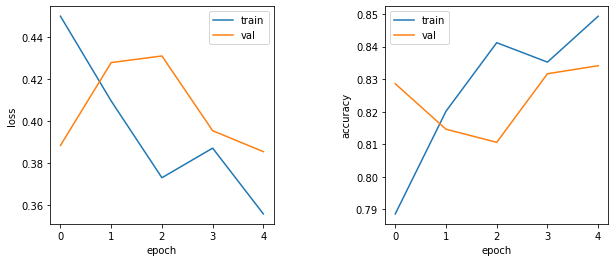

In [96]:
show_history(rnn_history)

SimpleRNN만을 사용해서 검증점수가 83점정도로 괜찮은 성능이 나왔다. SimpleRNN의 경우  전체 시퀀스가 아니라 순서대로 입력된 단어만 사용해 학습을해서 긴 시퀀스를 학습하는것이 어렵다고 한다. 이론적으로 SimpleRNN셀은 이전의 모든 타임스텝의 정보를 유지할 수 있지만 그래디언트 소실 등의 문제로 피드포워드 네트워크에 층을 많이 추가할수록 훈련성과가 좋지않다고 한다. 

하지만 감정분류문제는 간단하게 어떤 단어가 자주등장하는지 확인하면되기때문인지  SimpleRNN 모델만으로도 분류가 잘되는것 같다. 

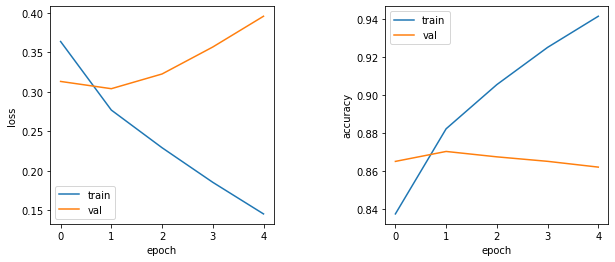

In [97]:
show_history(lstm_history)

LSTM 모델의성능은 훈련이 될수록 과적합양상을 보이긴하지만 검증점수가 86점 이상으로 안정적이다. 

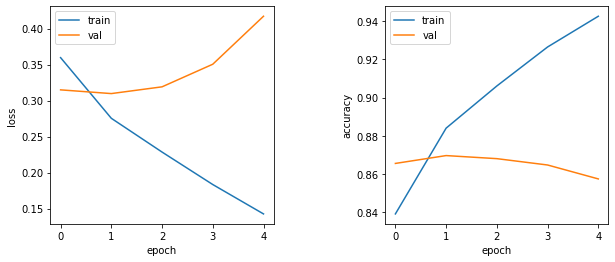

In [99]:
show_history(gru_history)

GRU모델 역시 LSTM 모델과 비슷한 성능을 보여주고 있다.

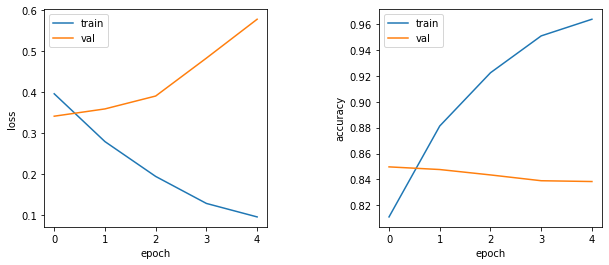

In [46]:
show_history(cnn_history)

합성곱 레이어를 결합한 모델의 경우 필터사이즈를 7개에서 10개로 늘리니 성능이 75%-> 83%로 향상되었다. 

# 5. 학습된 Embedding 레이어 분석

 감성 분류 모델의 학습이 잘 되었다면, Embedding 레이어에 학습된 우리의 워드 벡터들도 의미 공간상에 유의미한 형태로 학습되었을 것 gensim 라이브러리를 이용하여 확인해보자

- gensim : 자연어를 벡터로 변환하는데 필요한 기능을 제공하는 라이브러리
 - Word2Vec: 단어를 벡터로 변화는 기능으로 단어마다 차례대로 인덱싱을 하여 벡터화 하지 않고, 유사한 단어들을 비슷한 방향과 힘의 벡터를 갖도록 단어를 벡터화 시켜준다.
 - most_similar: 가장 유사한 단어들을 보여줌 (topn=10 : 비슷한단어 10개)
 
 
### 위 모델들중  LSTM모델로 임베딩 레이어를 분석해보겠다.


In [129]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/project/exp06_Movie_Review/data/word2vec_naver.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, embedding_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = lstm_model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [141]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)

vectors = word_vectors.similar_by_word('재밌')
vectors

[('강추', 0.9031942486763),
 ('완벽', 0.8860867023468018),
 ('담아낸', 0.8854650855064392),
 ('정점', 0.8684790730476379),
 ('재미있', 0.8683465719223022),
 ('재해석', 0.8670273423194885),
 ('곽', 0.8622673153877258),
 ('멋지', 0.8544442653656006),
 ('잼', 0.8535824418067932),
 ('걸작', 0.8524869680404663)]

In [139]:
vectors = word_vectors.similar_by_word('지겨운')
vectors

[('착오', 0.9292871952056885),
 ('조악', 0.9219530820846558),
 ('도자기', 0.9189692139625549),
 ('찌푸리', 0.9184261560440063),
 ('천박', 0.918212354183197),
 ('쪽팔리', 0.9167208075523376),
 ('사납', 0.9162719249725342),
 ('하품', 0.9129781723022461),
 ('후하', 0.9129486083984375),
 ('부조', 0.912632167339325)]

리뷰에서 감정이 잘들어나는 단어 "재밌, 지겨운"으로 테스트를 해보니 비슷한 단어들 가까이에 각 단어벡터가 위치하는것으로 보인다. 학습은 여기에서 마무리하고 한국어 Word2Vec 임베딩 활용하여 성능 개선하는 작업을 진행해보겠다.

# 6. 영화리뷰 감정분석 Word2Vec 적용

- [한국어 Word2Vec : Pre-trained word vectors of 30+ languages](https://github.com/Kyubyong/wordvectors)
 - 위 링크에서 Korean (w) 메뉴의 압축파일 다운로드
 - ko.bin 파일 이용
 - pip freeze명령어로 gensim 버전을 확인해보니 4.1.2이였다. gensim 버전을 3.x.x로 다운그레이드해주었다.
 ```
 # pip install --upgrade gensim==3.8.3
 ```

In [22]:
import gensim

pretrained_path = os.getenv('HOME')+'/aiffel/project/exp06_Movie_Review/data/ko.bin'
ko_model = gensim.models.Word2Vec.load(pretrained_path) # gensim 버전 다운그레이드 후 로드가 된다.

`similar_by_word`함수실행시 경고메세지가뜨며 self.wv.similar_by_word() 사용할것을 권장하였다. 관련함수 변경후 실행해보았다.

In [24]:
vectors = ko_model.wv.most_similar("재밌")
vectors

[('재미있', 0.7603887915611267),
 ('웃기', 0.7365726828575134),
 ('멋지', 0.657281756401062),
 ('슬프', 0.6381862163543701),
 ('안타깝', 0.6331009864807129),
 ('즐겁', 0.6227831840515137),
 ('맛있', 0.6146109104156494),
 ('우습', 0.6106981039047241),
 ('생각나', 0.6095916032791138),
 ('시끄럽', 0.6063516139984131)]

In [33]:
vectors = ko_model.wv.most_similar('지루')
vectors

[('답답', 0.7367106676101685),
 ('편안', 0.7046725749969482),
 ('솔직', 0.689364492893219),
 ('쓸쓸', 0.6880695819854736),
 ('차분', 0.6868932247161865),
 ('조용', 0.6765609383583069),
 ('냉정', 0.6706622838973999),
 ('자유분방', 0.6680829524993896),
 ('피곤', 0.6597293019294739),
 ('느긋', 0.659047544002533)]

이제 이전 스텝에서 학습했던 모델의 임베딩 레이어를 Word2Vec의 Pre-train된 벡터로 교체하여 다시 학습시켜 보겠다.

In [40]:
word2vec = ko_model.wv

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

In [43]:
from tensorflow.keras.initializers import Constant

pt_model = keras.Sequential()
pt_model.add(keras.layers.Embedding(vocab_size, embedding_dim,
                                     embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                     trainable=True)) # trainable을 True로 주면 Fine-tuning
pt_model.add(keras.layers.LSTM(128))
pt_model.add(keras.layers.Dense(8, activation='relu'))
pt_model.add(keras.layers.Dense(1, activation='sigmoid'))

pt_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

lstm_history = pt_model.fit(X_train, y_train, epochs=5,  validation_split=0.2)

Epoch 1/5
3655/3655 [==============================] - 25s 6ms/step - loss: 0.3810 - accuracy: 0.8258 - val_loss: 0.3192 - val_accuracy: 0.8646
Epoch 2/5
3655/3655 [==============================] - 24s 6ms/step - loss: 0.2845 - accuracy: 0.8790 - val_loss: 0.3072 - val_accuracy: 0.8717
Epoch 3/5
3655/3655 [==============================] - 23s 6ms/step - loss: 0.2415 - accuracy: 0.8995 - val_loss: 0.3122 - val_accuracy: 0.8695
Epoch 4/5
3655/3655 [==============================] - 23s 6ms/step - loss: 0.2012 - accuracy: 0.9178 - val_loss: 0.3344 - val_accuracy: 0.8706
Epoch 5/5
3655/3655 [==============================] - 24s 7ms/step - loss: 0.1614 - accuracy: 0.9349 - val_loss: 0.3656 - val_accuracy: 0.8658


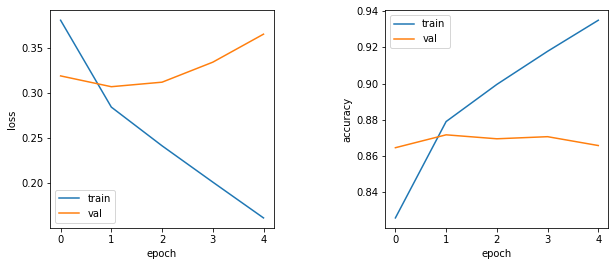

In [47]:
show_history(lstm_history)

한국어 Word2Vec에서 학습된 임베딩 벡터로 기존의 LSTM 모델에 넣어준 결과 정확도면에서는 크게 향상되지 않았지만  loss값은 경우 유의미할 정도로 줄어든 것을 알수 있었다.  LSTM 모델이 학습이 될 수록 과적합되는반면에 한국어 Word2Vec를 사용한 모델은 loss가 크게 늘지 않아 안정적이였다.

---
# 7. 정리

이번프로젝트에서는 텍스트 분류 문제에 대하여 여러가지 모델을 적용해보았다. RNN계열에 모델에 원핫인코딩된 텍스트 데이터를 넣는것보다 임베딩으로 넣어주는 방법이 자연어에 의미를 효과적으로 표현하여 학습에 도움이 된다는것을 알았다. 여러 모델로 테스트를 해보긴했지만 임베딩레이어로 입력을 넣어준 부분때문인지 대부분 80%이상의 좋은 성능을 보여준것같다. 합성곱 레이어에 텍스트로 인코딩된 데이터를 접목시킨부분도 흥미로웠는데, 성능 또한 RNN계열모델에 뒤지지 않아 신기했다.  

지난 4번째 Exploration에 이어 다시한번 텍스트에 대한 토큰화와 벡터화하는 과정을 가져 자연어에 대해 전처리 하는 부분이 좀더 익숙해진것 같다. 그리고 아직 자연어 처리 모델을 많이 겪어보지않아 잘모르겠지만 에폭 5회 안에서 과적합이 발생하고 있는것 같다.  이부분에 대한 연구는 다음 숙제로 남기고 프로젝트를 마치겠다.

---
# Reference
- 자연어처리 : [링크](https://aikorea.org/blog/rnn-tutorial-1/)
- 자연어처리를 위한 1D CNN : [링크](https://wikidocs.net/80437)